# 05 - Results

In [427]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping

from models.X_RCC import XRCC, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

In [428]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 200

In [429]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
clustering_results_path  = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters.nc'
literature_results_path  = f'../data/preprocessed/external/monsoon_dates.nc'

results_path_image  = f'../data/results/images/bias_results_{n_iters}iters.png'
results_path_image_centered  = f'../data/results/images/bias_results_{n_iters}iters_centered.png'

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

# Mask boundary
mask_boundary = world_boundary[world_boundary["GID_0"].isin(['IND','NPL','BGD'])]

In [430]:
clustering_results = xr.open_dataset(clustering_results_path)
literature_results = xr.open_dataset(literature_results_path)

In [431]:
a = clustering_results.sel(cluster=0).__xarray_dataarray_variable__
b = literature_results.sel(cluster=0).date
onset_diff = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='onset')

a = a-a.mean()
b = b-b.mean()
onset_diff_centered = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='onset')

a = clustering_results.sel(cluster=1).__xarray_dataarray_variable__
b = literature_results.sel(cluster=1).date
withdrawal_diff = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='withdrawal')

a = a-a.mean()
b = b-b.mean()
withdrawal_diff_centered = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='withdrawal')

tota = xr.concat([onset_diff,withdrawal_diff], dim='season_idx')
tota_centered = xr.concat([onset_diff_centered, withdrawal_diff_centered], dim='season_idx')

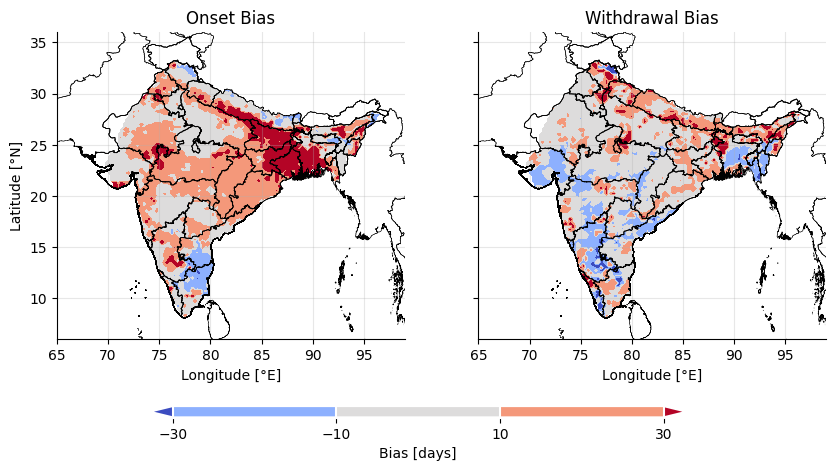

In [432]:
plot = tota.plot.contourf(col='season_idx', col_wrap=2, vmin=-30, vmax=30, levels=4, add_colorbar=False, figsize=(9,4), cmap='coolwarm')

standard_format( plot,
                 country_boundary   = country_boundary,
                 world_boundary     = world_boundary,
                 custom_cbar        = True
                )

plot.axes[0][0].set_title('Onset Bias', size=12)
plot.axes[0][1].set_title('Withdrawal Bias', size=12)
plot.cbar.set_label('Bias [days]')


plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

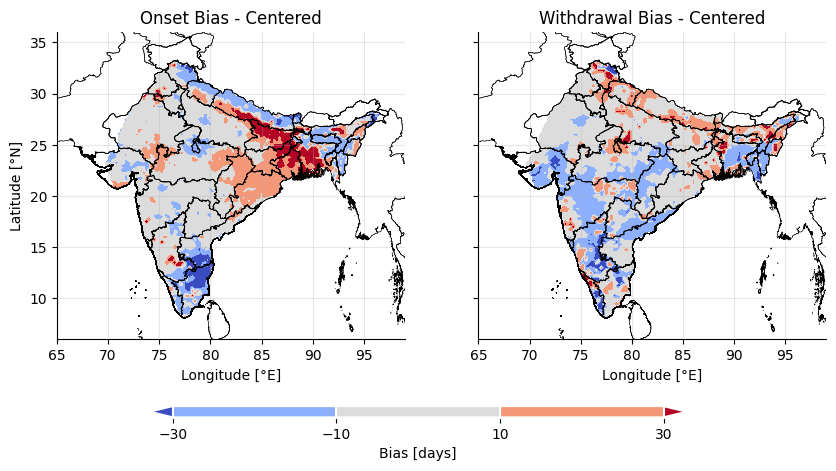

In [433]:
plot = tota_centered.plot.contourf(col='season_idx', col_wrap=2, vmin=-30, vmax=30, levels=4, add_colorbar=False, figsize=(9,4), cmap='coolwarm')

standard_format( plot,
                 country_boundary   = country_boundary,
                 world_boundary     = world_boundary,
                 custom_cbar        = True
                )

plot.axes[0][0].set_title('Onset Bias - Centered', size=12)
plot.axes[0][1].set_title('Withdrawal Bias - Centered', size=12)
plot.cbar.set_label('Bias [days]')

plt.savefig(results_path_image_centered, dpi=300, bbox_inches='tight', transparent=False)

In [434]:
dataset_tp = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/total_precipitation/precipitation_1980_2011_15dd.nc').tp.load()

In [439]:
dataset_tp_bengali = dataset_tp.sel(lon = slice(85,90), lat = slice(25,21)).groupby('time.dayofyear').mean() * 24*1000
clustering_results_bengali = clustering_results.sel(lon = slice(85,90), lat = slice(25,21))
literature_results_bengali = literature_results.sel(lon = slice(85,90), lat = slice(21,25))

In [440]:
cluster_mean = clustering_results_bengali.sel(cluster=0).mean().__xarray_dataarray_variable__.values
literature_mean = literature_results_bengali.sel(cluster=0).mean().date.values

<Axes: title={'center': 'spatial_ref = 0, dayofyear = 1'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

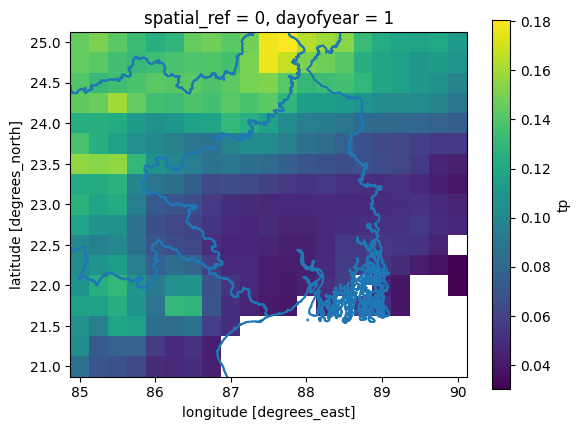

In [441]:
fig, ax = plt.subplots(1,1)
dataset_tp_bengali.isel(dayofyear=0).plot(ax = ax)
country_boundary.boundary.plot(ax=ax)

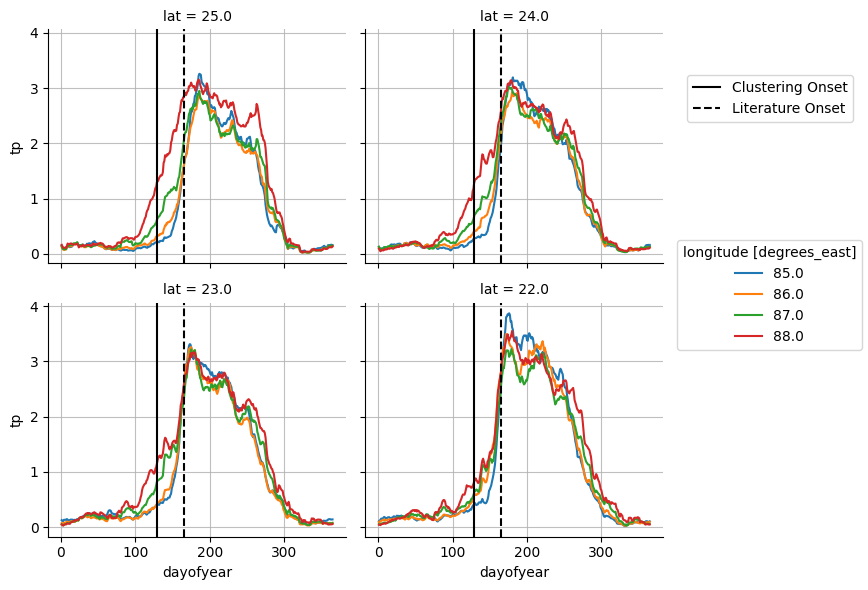

In [442]:
plot = dataset_tp_bengali.isel(lat = [0,4,8,12], lon = [0,4,8,12]).plot(col='lat', hue='lon', col_wrap=2)

for ax in plot.axs.ravel():

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(alpha=0.8)
    ax.axvline(cluster_mean, color='k', label='Clustering Onset')
    ax.axvline(literature_mean, color='k', linestyle='--', label='Literature Onset')

plot.axs[1][1].legend(ncol=1, loc='upper right', bbox_to_anchor=(1.66, 2), fancybox=True)
